# Modeling & Prediction


In [1]:
# Packages
import pandas as pd
import numpy as np

import arcticdb as adb

import pycaret.regression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt



In [2]:
# Configurations
DB_PATH = '/Users/zway/Desktop/BTC_Project/DB'

In [3]:
# set up ArcticDB
ac = adb.Arctic(f"lmdb://{DB_PATH}")
engineered_lib = ac.get_library('engineered_data')

In [6]:
# load features from main library
df_base = engineered_lib.read('BTC_engineered_sample').data
df_cleaned = df_base.dropna()

# split train & test df
train_df, test_df = train_test_split(df_cleaned, test_size=0.3, random_state=42)

df_base.head(), train_df.head(), test_df.head()

(           start_time            end_time    mean_price  max_price  min_price  \
 0 2023-07-01 00:00:00 2023-07-01 00:06:00  30412.208333    30427.2    30392.3   
 1 2023-07-01 00:06:00 2023-07-01 00:12:00  30432.991667    30449.8    30414.9   
 2 2023-07-01 00:12:00 2023-07-01 00:18:00  30403.083333    30450.3    30361.4   
 3 2023-07-01 00:18:00 2023-07-01 00:24:00  30411.458333    30428.8    30393.2   
 4 2023-07-01 00:24:00 2023-07-01 00:30:00  30435.150000    30467.4    30410.1   
 
    price_range  norm_vol   norm_fd  
 0         34.9  1.000000  0.036554  
 1         34.9  0.999317  0.043081  
 2         88.9  1.000000  0.152742  
 3         35.6  0.400340  0.050914  
 4         57.3  0.643865  0.060487  ,
               start_time            end_time    mean_price  max_price  \
 1451 2023-07-07 01:06:00 2023-07-07 01:12:00  30024.825000    30053.0   
 1321 2023-07-06 12:06:00 2023-07-06 12:12:00  30695.075000    30744.7   
 6804 2023-07-29 08:24:00 2023-07-29 08:30:00  29264.90

In [7]:
# train regression model
vol_reg_exp = pycaret.regression.setup(
    data=train_df,
    target='norm_vol',
    ignore_features=['start_time', 'end_time', 'norm_fd'],
    session_id=42,
    verbose=False
)

vol_model = pycaret.regression.compare_models(fold=2)
vol_model = pycaret.regression.tune_model(vol_model, fold=2)
pycaret.regression.save_model(vol_model, 'sample_vol_model')
vol_result = pycaret.regression.pull()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.0241,0.0031,0.0551,0.7004,0.0419,0.2544,0.0700
ridge,Ridge Regression,0.0273,0.0033,0.0571,0.6767,0.0433,0.3809,0.4050
lar,Least Angle Regression,0.0273,0.0033,0.0571,0.6767,0.0433,0.3808,0.0050
br,Bayesian Ridge,0.0273,0.0033,0.0571,0.6767,0.0433,0.3810,0.0050
lr,Linear Regression,0.0274,0.0033,0.0571,0.6766,0.0433,0.3818,1.1250
rf,Random Forest Regressor,0.0235,0.0033,0.0577,0.6715,0.0440,0.2107,0.0650
et,Extra Trees Regressor,0.0232,0.0034,0.0579,0.6684,0.0443,0.2110,0.0400
lightgbm,Light Gradient Boosting Machine,0.0247,0.0034,0.0584,0.6636,0.0443,0.2486,0.5850
en,Elastic Net,0.0302,0.0036,0.0595,0.6503,0.0458,0.4587,0.4000
huber,Huber Regressor,0.0284,0.0038,0.0614,0.6259,0.0474,0.3146,0.4000


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0234,0.0029,0.0541,0.6809,0.0417,0.2677
1,0.0237,0.0032,0.0565,0.7119,0.0424,0.2261
Mean,0.0236,0.0031,0.0553,0.6964,0.0420,0.2469
Std,0.0001,0.0001,0.0012,0.0155,0.0004,0.0208


Fitting 2 folds for each of 10 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved


In [8]:
# train regression model
fd_reg_exp = pycaret.regression.setup(
    data=train_df,
    target='norm_fd',
    ignore_features=['start_time', 'end_time', 'norm_vol'],
    session_id=42,
    verbose=False
)

fd_model = pycaret.regression.compare_models(fold=2)
fd_model = pycaret.regression.tune_model(fd_model, fold=2)
pycaret.regression.save_model(fd_model, 'sample_fd_model')
fd_result = pycaret.regression.pull()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.0066,0.0001,0.0112,0.9059,0.0096,0.2811,0.0100
ridge,Ridge Regression,0.0069,0.0001,0.0117,0.8954,0.0101,0.2987,0.0100
lar,Least Angle Regression,0.0069,0.0001,0.0117,0.8954,0.0101,0.2991,0.0050
br,Bayesian Ridge,0.0069,0.0001,0.0117,0.8954,0.0101,0.2987,0.0050
lr,Linear Regression,0.0069,0.0001,0.0117,0.8952,0.0101,0.3008,0.0400
et,Extra Trees Regressor,0.0075,0.0003,0.0158,0.8098,0.0125,0.3153,0.0400
ada,AdaBoost Regressor,0.0080,0.0003,0.0160,0.8038,0.0126,0.4979,0.0350
en,Elastic Net,0.0112,0.0004,0.0192,0.7209,0.0162,0.7540,0.0200
rf,Random Forest Regressor,0.0075,0.0004,0.0193,0.7186,0.0148,0.3053,0.0500
lightgbm,Light Gradient Boosting Machine,0.0077,0.0004,0.0195,0.7143,0.0151,0.3051,0.2750


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0064,0.0001,0.0115,0.9113,0.0094,0.2712
1,0.0068,0.0001,0.0108,0.9028,0.0098,0.2856
Mean,0.0066,0.0001,0.0111,0.9070,0.0096,0.2784
Std,0.0002,0.0000,0.0004,0.0042,0.0002,0.0072


Fitting 2 folds for each of 10 candidates, totalling 20 fits
Transformation Pipeline and Model Successfully Saved


In [10]:
# Predicting norm_vol and norm_fd on the test set
# load models to ensure they are in the memory
vol_model = pycaret.regression.load_model('sample_vol_model')
fd_model = pycaret.regression.load_model('sample_fd_model')

# drop target columns
vol_test_df = test_df.drop(columns=['norm_vol'], errors='ignore')
fd_test_df = test_df.drop(columns=['norm_fd'], errors='ignore')

# predict norm_vol and norm_fd
test_df['pred_vol'] = pycaret.regression.predict_model(vol_model, data=vol_test_df)['prediction_label']
test_df['pred_fd'] = pycaret.regression.predict_model(fd_model, data=fd_test_df)['prediction_label']

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [11]:
test_df

,start_time,end_time,mean_price,max_price,min_price,price_range,norm_vol,norm_fd,pred_vol,pred_fd
2187,2023-07-10 02:42:00,2023-07-10 02:48:00,30093.991667,30154.9,30070.5,84.4,0.293620,0.082681,0.264578,0.090236
4559,2023-07-19 23:54:00,2023-07-20 00:00:00,29890.650000,29905.1,29877.1,28.0,0.066698,0.028721,0.065075,0.027856
7002,2023-07-30 04:12:00,2023-07-30 04:18:00,29285.333333,29288.2,29282.1,6.1,0.008712,0.001741,0.009027,0.004211
413,2023-07-02 17:18:00,2023-07-02 17:24:00,30529.650000,30552.1,30460.0,92.1,0.333397,0.070496,0.277817,0.095004
6068,2023-07-26 06:48:00,2023-07-26 06:54:00,29178.487500,29183.6,29172.6,11.0,0.015768,0.006963,0.015967,0.009493
...,...,...,...,...,...,...,...,...,...,...
6342,2023-07-27 10:12:00,2023-07-27 10:18:00,29516.912500,29521.5,29513.2,8.3,0.011761,0.010444,0.009562,0.006620
3780,2023-07-16 18:00:00,2023-07-16 18:06:00,30364.216667,30369.4,30358.5,10.9,0.025560,0.005657,0.055562,0.009299
5467,2023-07-23 18:42:00,2023-07-23 18:48:00,30136.225000,30149.4,30120.8,28.6,0.067572,0.031767,0.084102,0.028353
6431,2023-07-27 19:06:00,2023-07-27 19:12:00,29114.775000,29137.4,29092.7,44.7,0.064215,0.053525,0.066284,0.045931


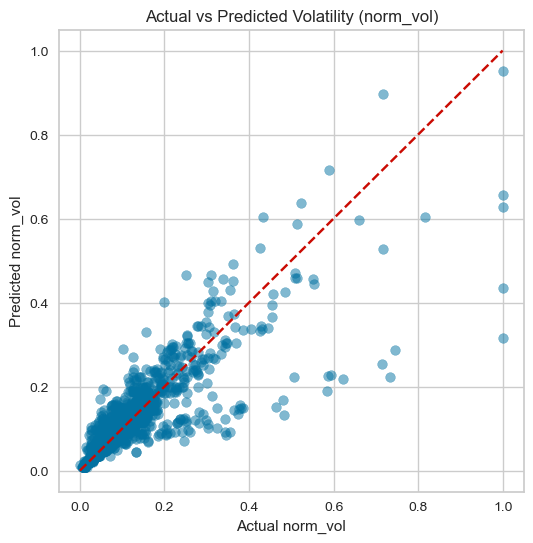

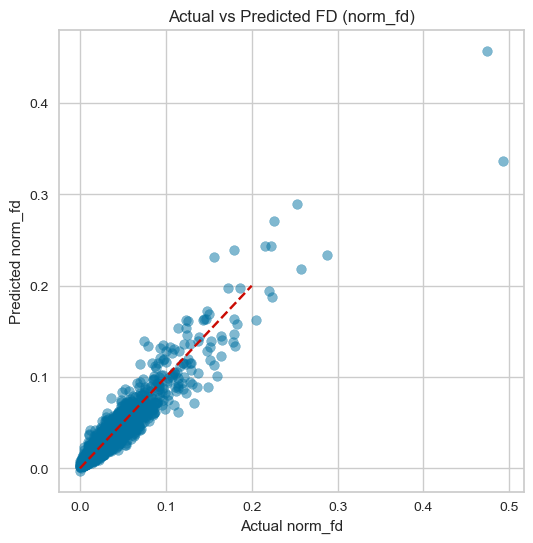

In [15]:
# Volume prediction comparison
plt.figure(figsize=(6, 6))
plt.scatter(test_df['norm_vol'], test_df['pred_vol'], alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')  # y = x line
plt.xlabel('Actual norm_vol')
plt.ylabel('Predicted norm_vol')
plt.title('Actual vs Predicted Volatility (norm_vol)')
plt.grid(True)
plt.show()

# Fractal Dimension prediction comparison
plt.figure(figsize=(6, 6))
plt.scatter(test_df['norm_fd'], test_df['pred_fd'], alpha=0.5)
plt.plot([0, 0.2], [0, 0.2], 'r--')  # y = x line, narrower range
plt.xlabel('Actual norm_fd')
plt.ylabel('Predicted norm_fd')
plt.title('Actual vs Predicted FD (norm_fd)')
plt.grid(True)
plt.show()

In [ ]:
def print_metrics(true, pred, label=''):
    rmse = mean_squared_error(true, pred, squared=False)
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    print(f'{label} — RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}')

print_metrics(test_df['norm_vol'], test_df['pred_vol'], 'Volatility')
print_metrics(test_df['norm_fd'], test_df['pred_fd'], 'Fractal Dimension')

Volatility — RMSE: 0.0543, MAE: 0.0239, R2: 0.7301
Fractal Dimension — RMSE: 0.0111, MAE: 0.0070, R2: 0.8984


# Modeling & Result 2
Modeling based on optimized features: include volume and replace volatility by Garman-Klass volatitliy

In [8]:
# load features from main library
df_base_updated = engineered_lib.read('BTC_engineered_sample_2').data
df_cleaned = df_base_updated.dropna()

# split train & test df
train_df, test_df = train_test_split(df_cleaned, test_size=0.3, random_state=42)

df_base_updated.head(), train_df.head(), test_df.head()

(           start_time            end_time    mean_price  max_price  min_price  \
 0 2023-07-01 00:00:00 2023-07-01 00:06:00  30412.208333    30427.2    30392.3   
 1 2023-07-01 00:06:00 2023-07-01 00:12:00  30432.991667    30449.8    30414.9   
 2 2023-07-01 00:12:00 2023-07-01 00:18:00  30403.083333    30450.3    30361.4   
 3 2023-07-01 00:18:00 2023-07-01 00:24:00  30411.458333    30428.8    30393.2   
 4 2023-07-01 00:24:00 2023-07-01 00:30:00  30435.150000    30467.4    30410.1   
 
    price_range  volume_mean  norm_gk_vol   norm_fd  
 0         34.9     0.000037     1.000000  0.036554  
 1         34.9     0.000030     0.691906  0.043081  
 2         88.9     0.000063     1.000000  0.152742  
 3         35.6     0.000032     0.567270  0.050914  
 4         57.3     0.000028     0.416537  0.060487  ,
               start_time            end_time    mean_price  max_price  \
 1451 2023-07-07 01:06:00 2023-07-07 01:12:00  30024.825000    30053.0   
 1321 2023-07-06 12:06:00 2023-07

In [10]:
# train regression model for volatility
vol_reg_exp = pycaret.regression.setup(
    data=train_df,
    target='norm_gk_vol',
    ignore_features=['start_time', 'end_time', 'norm_fd'],
    session_id=42,
    verbose=False
)

vol_model = pycaret.regression.compare_models(fold=2)
vol_model = pycaret.regression.tune_model(vol_model, fold=2)
pycaret.regression.save_model(vol_model, 'sample_vol_model_2')
vol_result = pycaret.regression.pull()

fd_reg_exp = pycaret.regression.setup(
    data=train_df,
    target='norm_fd',
    ignore_features=['start_time', 'end_time', 'norm_gk_vol'],
    session_id=42,
    verbose=False,
    normalize=True
)

fd_model = pycaret.regression.compare_models(fold=2)
fd_model = pycaret.regression.tune_model(fd_model, fold=2)
pycaret.regression.save_model(fd_model, 'sample_fd_model_2')
fd_result = pycaret.regression.pull()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0305,0.0033,0.0577,0.7191,0.0430,0.3037,0.0350
lightgbm,Light Gradient Boosting Machine,0.0309,0.0034,0.0583,0.7134,0.0435,0.3205,0.2950
rf,Random Forest Regressor,0.0309,0.0037,0.0602,0.6962,0.0445,0.3157,0.0650
gbr,Gradient Boosting Regressor,0.0313,0.0037,0.0604,0.6931,0.0449,0.3408,0.0750
lr,Linear Regression,0.0353,0.0043,0.0653,0.6372,0.0491,0.4621,0.0100
lar,Least Angle Regression,0.0353,0.0043,0.0653,0.6371,0.0491,0.4609,0.0050
ridge,Ridge Regression,0.0368,0.0044,0.0661,0.6275,0.0497,0.4953,0.0050
br,Bayesian Ridge,0.0368,0.0044,0.0662,0.6275,0.0497,0.4956,0.0050
en,Elastic Net,0.0394,0.0047,0.0683,0.6077,0.0520,0.5699,0.0150
knn,K Neighbors Regressor,0.0389,0.0053,0.0727,0.5544,0.0551,0.4545,0.0150


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0344,0.0036,0.0600,0.6410,0.0461,0.6478
1,0.0382,0.0055,0.0742,0.6034,0.0538,0.4737
Mean,0.0363,0.0046,0.0671,0.6222,0.0500,0.5607
Std,0.0019,0.0010,0.0071,0.0188,0.0039,0.0871


Fitting 2 folds for each of 10 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.0066,0.0001,0.0110,0.9084,0.0096,0.2860,0.0100
lar,Least Angle Regression,0.0069,0.0001,0.0117,0.8967,0.0100,0.3018,0.0050
br,Bayesian Ridge,0.0068,0.0001,0.0117,0.8967,0.0100,0.3023,0.0050
lr,Linear Regression,0.0069,0.0001,0.0117,0.8966,0.0100,0.3015,0.0150
ridge,Ridge Regression,0.0068,0.0001,0.0117,0.8966,0.0100,0.3027,0.0050
omp,Orthogonal Matching Pursuit,0.0069,0.0001,0.0118,0.8934,0.0101,0.2946,0.0050
et,Extra Trees Regressor,0.0072,0.0003,0.0154,0.8178,0.0121,0.2947,0.0500
ada,AdaBoost Regressor,0.0084,0.0003,0.0160,0.8017,0.0127,0.5634,0.0200
knn,K Neighbors Regressor,0.0075,0.0003,0.0166,0.7876,0.0130,0.3236,0.0100
dt,Decision Tree Regressor,0.0094,0.0003,0.0183,0.7460,0.0149,0.3660,0.0100


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0065,0.0001,0.0114,0.9122,0.0094,0.2972
1,0.0068,0.0001,0.0106,0.9050,0.0097,0.2881
Mean,0.0066,0.0001,0.0110,0.9086,0.0096,0.2927
Std,0.0001,0.0000,0.0004,0.0036,0.0001,0.0046


Fitting 2 folds for each of 10 candidates, totalling 20 fits
Transformation Pipeline and Model Successfully Saved


In [11]:
# Predicting norm_vol and norm_fd on the test set
# load models to ensure they are in the memory
vol_model = pycaret.regression.load_model('sample_vol_model_2')
fd_model = pycaret.regression.load_model('sample_fd_model_2')

# drop target columns
vol_test_df = test_df.drop(columns=['norm_gk_vol'], errors='ignore')
fd_test_df = test_df.drop(columns=['norm_fd'], errors='ignore')

# predict norm_vol and norm_fd
test_df['pred_vol'] = pycaret.regression.predict_model(vol_model, data=vol_test_df)['prediction_label']
test_df['pred_fd'] = pycaret.regression.predict_model(fd_model, data=fd_test_df)['prediction_label']

test_df


Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


,start_time,end_time,mean_price,max_price,min_price,price_range,volume_mean,norm_gk_vol,norm_fd,pred_vol,pred_fd
2187,2023-07-10 02:42:00,2023-07-10 02:48:00,30093.991667,30154.9,30070.5,84.4,0.001398,0.158050,0.082681,0.282274,0.090772
4559,2023-07-19 23:54:00,2023-07-20 00:00:00,29890.650000,29905.1,29877.1,28.0,0.000702,0.074910,0.028721,0.079963,0.028100
7002,2023-07-30 04:12:00,2023-07-30 04:18:00,29285.333333,29288.2,29282.1,6.1,0.000029,0.031805,0.001741,0.022502,0.005693
413,2023-07-02 17:18:00,2023-07-02 17:24:00,30529.650000,30552.1,30460.0,92.1,0.000112,0.395694,0.070496,0.315823,0.095458
6068,2023-07-26 06:48:00,2023-07-26 06:54:00,29178.487500,29183.6,29172.6,11.0,0.000085,0.022123,0.006963,0.045720,0.011107
...,...,...,...,...,...,...,...,...,...,...,...
6342,2023-07-27 10:12:00,2023-07-27 10:18:00,29516.912500,29521.5,29513.2,8.3,0.000018,0.014847,0.010444,0.029919,0.007876
3780,2023-07-16 18:00:00,2023-07-16 18:06:00,30364.216667,30369.4,30358.5,10.9,0.000023,0.056425,0.005657,0.071190,0.009508
5467,2023-07-23 18:42:00,2023-07-23 18:48:00,30136.225000,30149.4,30120.8,28.6,0.000093,0.054132,0.031767,0.109156,0.029008
6431,2023-07-27 19:06:00,2023-07-27 19:12:00,29114.775000,29137.4,29092.7,44.7,0.000117,0.092365,0.053525,0.094276,0.048126


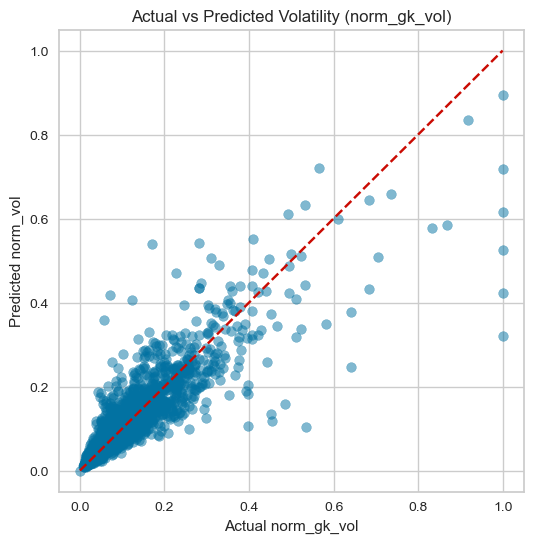

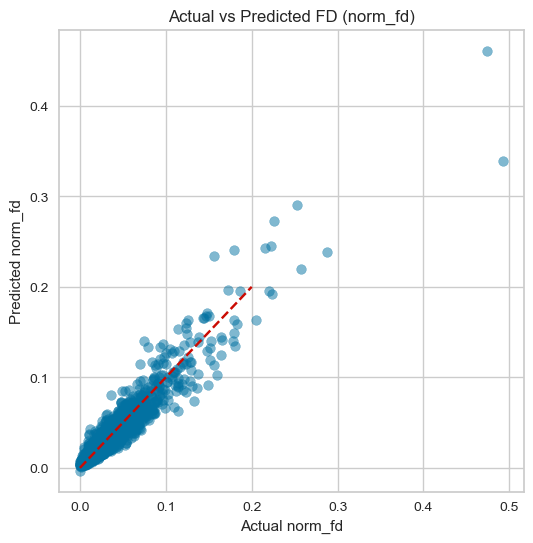

In [12]:
# Volume prediction comparison
plt.figure(figsize=(6, 6))
plt.scatter(test_df['norm_gk_vol'], test_df['pred_vol'], alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')  # y = x line
plt.xlabel('Actual norm_gk_vol')
plt.ylabel('Predicted norm_vol')
plt.title('Actual vs Predicted Volatility (norm_gk_vol)')
plt.grid(True)
plt.show()

# Fractal Dimension prediction comparison
plt.figure(figsize=(6, 6))
plt.scatter(test_df['norm_fd'], test_df['pred_fd'], alpha=0.5)
plt.plot([0, 0.2], [0, 0.2], 'r--')  # y = x line, narrower range
plt.xlabel('Actual norm_fd')
plt.ylabel('Predicted norm_fd')
plt.title('Actual vs Predicted FD (norm_fd)')
plt.grid(True)
plt.show()

In [13]:
def print_metrics(true, pred, label=''):
    rmse = mean_squared_error(true, pred, squared=False)
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    print(f'{label} — RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}')

print_metrics(test_df['norm_gk_vol'], test_df['pred_vol'], 'Volatility')
print_metrics(test_df['norm_fd'], test_df['pred_fd'], 'Fractal Dimension')

Volatility — RMSE: 0.0563, MAE: 0.0308, R2: 0.7437
Fractal Dimension — RMSE: 0.0110, MAE: 0.0070, R2: 0.9001
